# Time series analysis and visualization

In [1]:
# Hide all warnings
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import statsmodels as sm
import statsmodels.api

from tqdm import tqdm

In [69]:
from pylab import rcParams # Run-Control (default) parameters
    
rcParams['figure.figsize'] = 16, 8
rcParams['lines.linewidth'] = 4
rcParams['font.size'] = 26

<br>

## Time series analysis is for

* compact **dynamics description** of observable processes
* interpretation of dynamics and **estimation of impulse response**
* **forecasting** and simulation
* solution **optimal control** problems

<br>

## The objective of time series analysis

Construct a model of time series for _current value_ of **endogeneous** variable $y_t$

* by the _history_ of itself $$y_{:t} = (y_{t-1}, y_{t-2}, \ldots)$$
* by _current value_ of **exogeneous** variables $x_t$ and possibly by its _history_ too
$$
    y_t \approx \text{model}\bigl( t,\, y_{:t},\, x_t,\, x_{:t} \bigr)
\,. $$

Usually one forecasts a single time step ahead.

<br>

## Difference from other Machine Learning tasks

* Data are sequential
  * order of **time** has to be respected strictly due to not break the causality 

* Much attention to **extrapolation** — a forecast of future values related to observed sample
  * It is important to be sure that data do not leak from future to current and to past observations of train subsample during feature engineering and training the model

Thus features of the model can depend only on
* **endogeneous** variables $y_{t-1}, y_{t-2}, \ldots$, i.e. they are available to the moment $t-1$ _inclusively_
* **exogeneous** variables $x_t, x_{t-1}, \ldots$, i.e. they are available to the moment $t$ _inclusively_

<br>

## $CO_2$ concentration in atmosphere [dataset](https://www.co2.earth/weekly-co2)

In [133]:
dataset = pd.read_csv('./mauna_loa_atmospheric_c02.csv',
                      index_col=None, usecols=['date', 'WMLCO2'])

In [71]:
dataset.head()

,date,WMLCO2
0,1958-03-29,316.1
1,1958-04-05,317.3
2,1958-04-12,317.6
3,1958-04-19,317.5
4,1958-04-26,316.4


When you loads a time series within `Pandas` you have to set format of date and time explicitly

In [72]:
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')

Create the index for loaded data: it will be **weekly periodical index**. We will get data with regular frequency.

In [73]:
dataset = dataset.set_index('date').to_period('W')

In [74]:
dataset.head()

,WMLCO2
date,
1958-03-24/1958-03-30,316.1
1958-03-31/1958-04-06,317.3
1958-04-07/1958-04-13,317.6
1958-04-14/1958-04-20,317.5
1958-04-21/1958-04-27,316.4


Plot dynamics of the time series

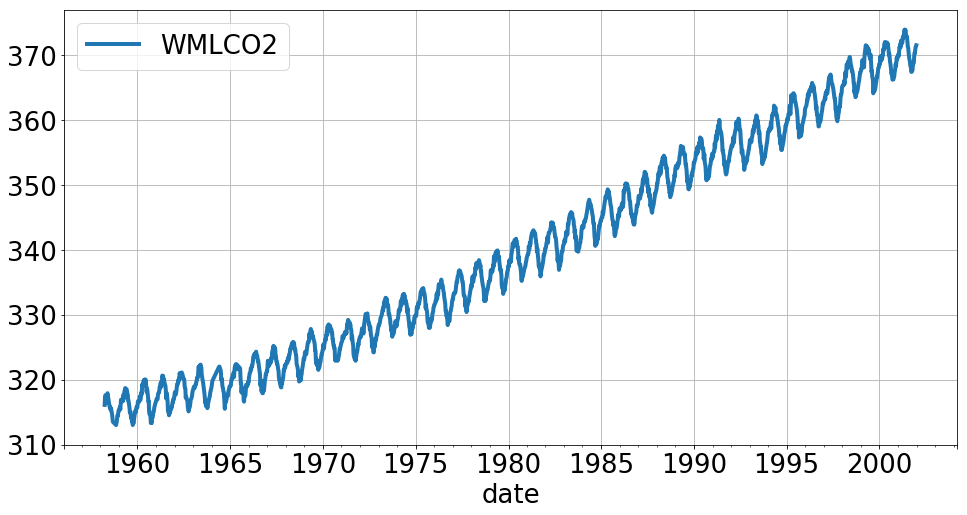

In [75]:
dataset.plot()

plt.grid(which='major', axis='both')

Aggregate weekly data to monthly

In [76]:
dataset = dataset.to_timestamp()

dataset = dataset.resample('M').mean()

In [77]:
dataset.head()

,WMLCO2
date,
1958-03-31,316.700
1958-04-30,317.100
1958-05-31,317.700
1958-06-30,315.800
1958-07-31,315.575


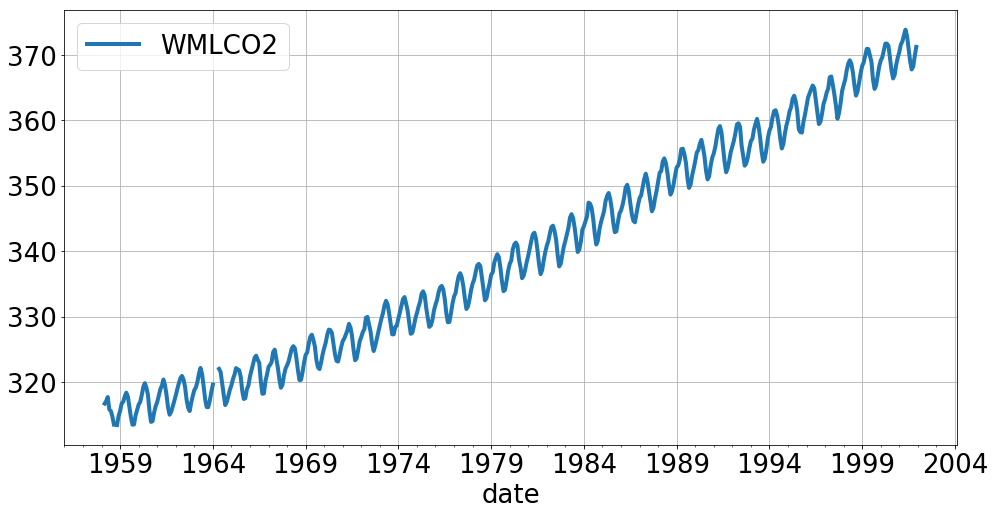

In [79]:
dataset.plot()

plt.grid(which='major', axis='both')

Create summary statistics

In [80]:
print('Series {1}, Observations {0}'.format(*dataset.shape))

dataset.describe().T.head()

Series 1, Observations 526


,count,mean,std,min,25%,50%,75%,max
WMLCO2,522.0,339.794055,17.090851,313.425,324.185,337.9825,354.545,373.825


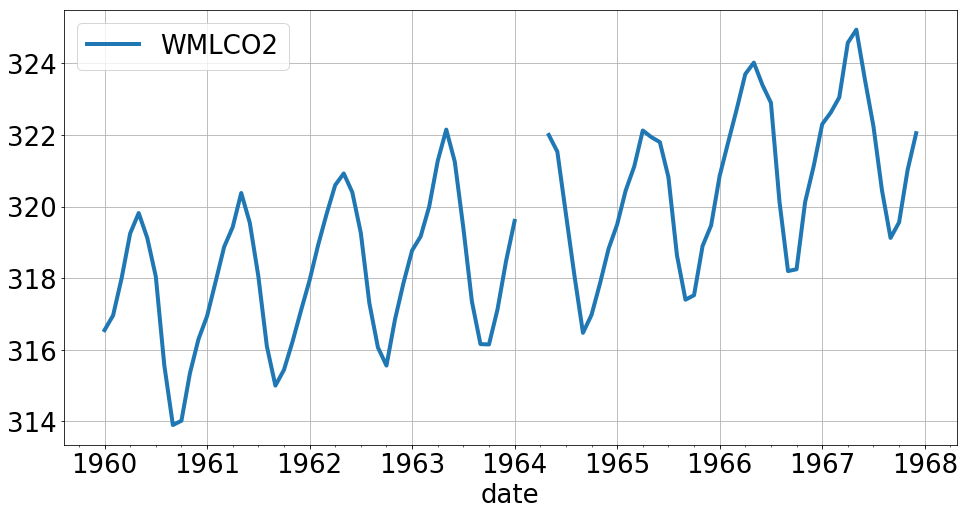

In [81]:
dataset.loc['1960':'1967'].plot()

plt.grid(which='major', axis='both')

### Missed values

In [82]:
maginfy_slice = slice('1960', '1967')

Missed values can be filled by

1) last known observable
  * **+** doesn't look through the future
  * **-** can't fill the beginning of the series
  * **-** doesn't account specificity of the series

In [83]:
dataset_ff = dataset.fillna(method='ffill')

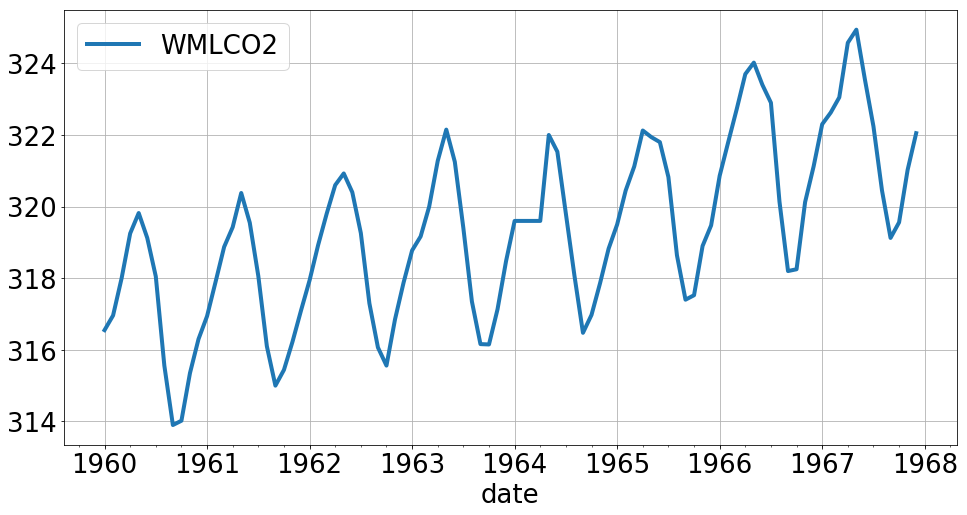

In [84]:
dataset_ff.loc[maginfy_slice].plot()

plt.grid(which='major', axis='both')

2) iterpolation of the neighboring values

* **+** smooth peaks
* **-** doesn't fill the ends of the series
* **-** slightly look through the future

In [85]:
dataset_linterp = dataset.interpolate(method='linear')

dataset_pinterp = dataset.interpolate(method='polynomial', order=2)

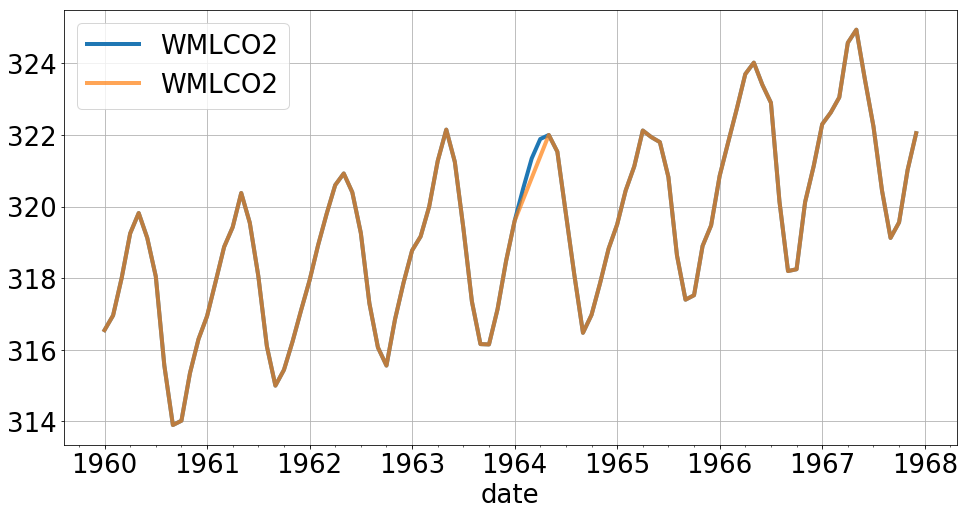

In [86]:
ax = dataset_pinterp.loc[maginfy_slice].plot()

dataset_linterp.loc[maginfy_slice].plot(ax=ax, linewidth=4, alpha=0.7)

plt.grid(which='major', axis='both')

3) exlude at all

* **+** doesn't change the values
* **-** break the regularity and related periodicity
* **-** deplete the sampling

In [87]:
dataset_drop = dataset.dropna()

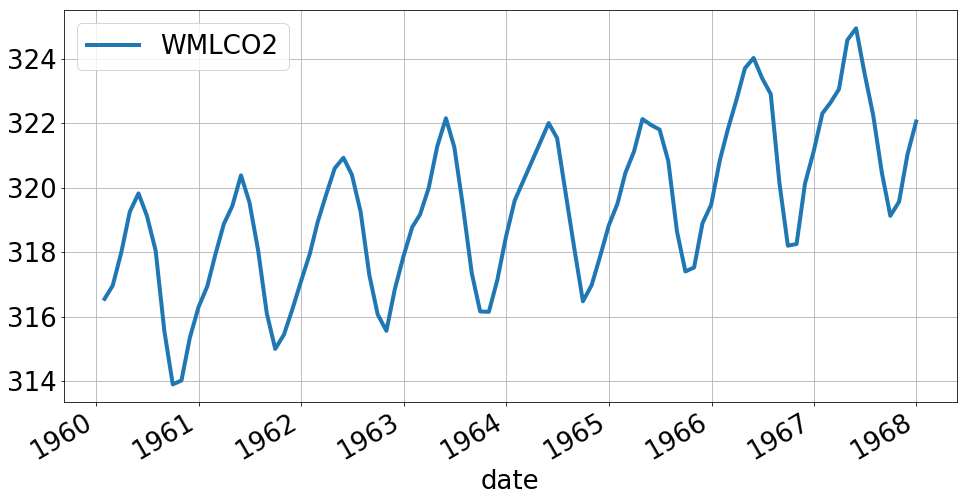

In [88]:
dataset_drop.loc[maginfy_slice].plot()

plt.grid(which='major', axis='both')

4) estimate by probabilty model

* **+** filling based on extracted patterns (learned dependencies)
* **-** it is needed to specify the model and to train it

5) smooth by splines or by local kernel model
* **+** explicitly accounts close in time observations
* **+** allows to increase the frequency of observations ("_resolution_")
* **+** allows to fill missed boundary values
* **-** look through the future far
* **-** it is needed to define th kernel and the model for extrapolation

Looking into the future can be ignorred if **missed values are minority**.

But if missed values are majority then it is needed to understand why it is happened in the sampling.

In [89]:
full_dataset = dataset_pinterp

Prepare train and test samplings in the ratio 3 to 1

In [90]:
holdout = full_dataset.loc['1991-01-01':]

dataset = full_dataset.loc[:'1990-12-31']

print(len(dataset), len(holdout))

394 132


Make sure the parts don't intersect

In [91]:
pd.concat([
    dataset.tail(),
    holdout.head()
], axis=1)

,WMLCO2,WMLCO2
date,,
1990-08-31,352.250,NaN
1990-09-30,350.950,NaN
1990-10-31,351.400,NaN
1990-11-30,353.075,NaN
1990-12-31,354.260,NaN
1991-01-31,NaN,354.925
1991-02-28,NaN,355.950
1991-03-31,NaN,357.400
1991-04-30,NaN,358.700


Store the bounds of the intervals explicitly

In [92]:
holdout_slice = slice(*holdout.index[[0, -1]])

print('Train sample from {} to {}'.format(*dataset.index[[0, -1]]))

print('Test sample from {} to {}'.format(holdout_slice.start, holdout_slice.stop))

Train sample from 1958-03-31 00:00:00 to 1990-12-31 00:00:00
Test sample from 1991-01-31 00:00:00 to 2001-12-31 00:00:00


Select the column of target variable

In [97]:
target_column = 'WMLCO2'

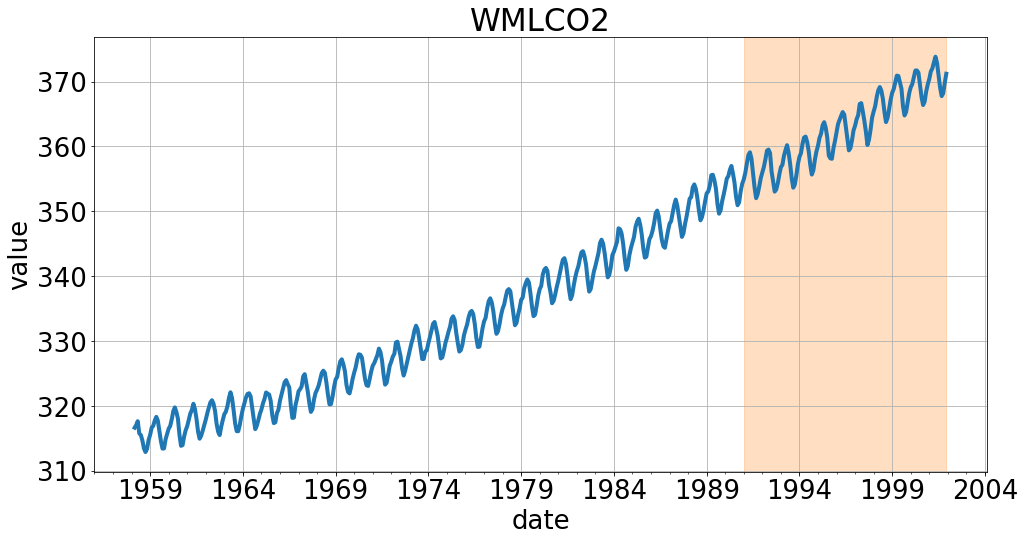

In [96]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='Date', ylabel='value', title=target_column) # 111 means 1 row 1 column 1st axes on the "grid"

# plot dynamics of entire time series
full_dataset[target_column].plot(ax=ax)

# highlight delayed interval for testing
ax.axvspan(holdout_slice.start, holdout_slice.stop,
           color='C1', alpha=0.25, zorder=-99)

ax.grid(which='major', axis='both');

<br>

# A property

**Stationarity** is a property of a process $\{y_t\}_{t\geq0}$ meaning
> probabilistic interconnections in the set $(y_{t_1},\,\ldots,\,y_{t_m})$ are invariant with respect to shift $s \neq 0$. 

That means
* **there are no special moments** in the time when statistical properties of observables are changing
* patterns are stable in time and are determined by **indentation of observables** relative to each other:
  * mean, dispersion, and autocorrelation doesn't depend on moment of time

## A ghost property

Stochastic processes in real problems are **almost always non-stationary**
* mean depends on time (there is a trend in the dynamics)
* calendar events (holidays or vacations)
* season periodicity
  * daily rhythm of power grid load
  * season temperature
  * yearly peak of monthly inflation in the beginning of year
* unpredictable structural drift
  * political decisions
  * blackouts
  * hysteresis

Thus majority of time series especially economic, climatic, and financial are non-stationary.

<br>

# Visualization and diagnosis of non-stationarity

Visualization in time series analysis allows to
* get preliminary picture of correlations
* select reasonable strategy of validation a model
* estimate if there is structural drift
  * leaps and gaps
  * clusters of intensive oscillations or periods of plateau
* diagnose non-stationarity: trend, seasonality, etc.

### A plot of moving statistics

Moving statistics of a series within window of length $N$ allow to discover changes in time

* **moving average** of time series level
$$
    m_t = \frac1{N} \sum_{s=t-N+1}^t y_s
$$
* **moving standard deviation** (scatter)
$$
    s_t = \sqrt{s^2_t}
        \,, \quad
    s^2_t = \frac1{N-1} \sum_{s=t-N+1}^t (y_s - m_t)^2
$$

In [107]:
rcParams['figure.figsize'] = 16, 10

In [108]:
def rolling_diagnostics(series, window=500):
    rolling = series.rolling(window)

    # Create top and bottom plots
    fig = plt.figure()
    ax_top = fig.add_subplot(211, title='Moving average', xlabel='Date', ylabel='value')
    ax_bottom = fig.add_subplot(212, title='Moving standard deviation',
                                sharex=ax_top, xlabel='Date', ylabel='std.')

    # Plot the graphs
    # series itself and moving average
    rolling.mean().plot(ax=ax_top)
    series.plot(ax=ax_top, color='black', lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which='major', axis='both')

    # moving std.
    rolling.std().plot(ax=ax_bottom)
    ax_bottom.grid(which='major', axis='both')

    fig.tight_layout()
    return fig

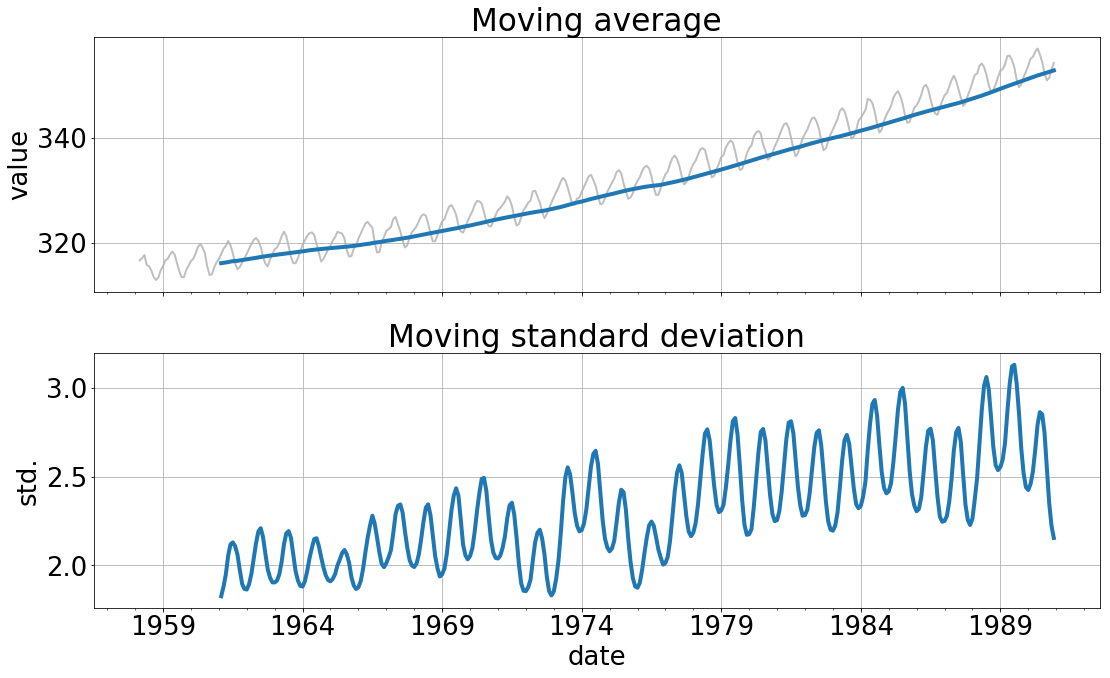

In [109]:
rolling_diagnostics(dataset[target_column], window=36);

The graphs show the trend in the dynamics of time series

<br>

### Rough estimate of seasonality

It is disarable to make season normalization relatively to trend.
Let's discover seasonality, for example monthly

In [110]:
def monthly_seasonality_diagnostics(series, fraction=0.66, period='month'):
    # Use non-parametric local linear regression to preliminary estimate the trend
    trend = sm.api.nonparametric.lowess(series, np.r_[:len(series)],
                                        frac=fraction, it=5)

    # Aggregate by months and calculate average and standard deviation
    by = getattr(series.index, period, 'month')
    season_groupby = (series - trend[:, 1]).groupby(by)
    seas_mean, seas_std = season_groupby.mean(), season_groupby.std()

    # Create subplots
    fig = plt.figure()
    ax_top = fig.add_subplot(211, title='Trend', xlabel='Date')
    ax_bottom = fig.add_subplot(212, title='Seasonality', xlabel=period)

    # Plot the graphs
    # The series and the trend
    pd.Series(trend[:, 1], index=series.index).plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # Seasonality and 90% normal confidence interval
    ax_bottom.plot(1 + np.r_[:len(seas_mean)], seas_mean, lw=2)
    ax_bottom.fill_between(1 + np.r_[:len(seas_mean)],
                           seas_mean - 1.96 * seas_std,
                           seas_mean + 1.96 * seas_std,
                           zorder=-10, color="C1", alpha=0.15)
    ax_bottom.grid(which="major", axis="both")


    fig.tight_layout()
    return fig

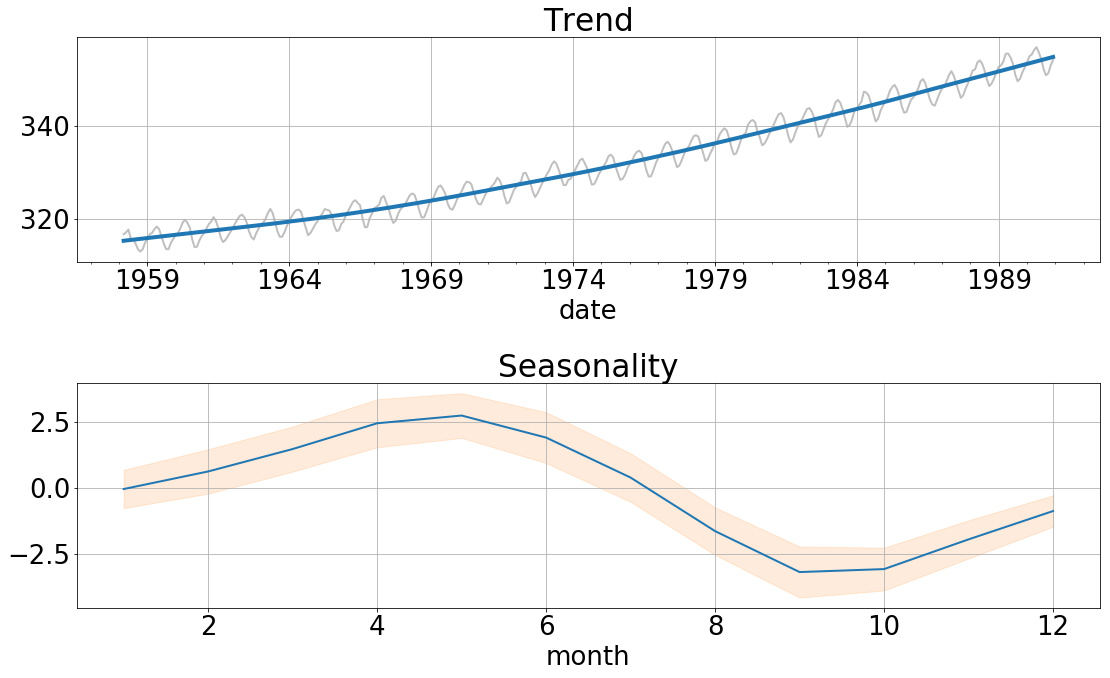

In [111]:
monthly_seasonality_diagnostics(dataset[target_column], fraction=0.33, period='month');

The graph shows the **monthly** seasonality in the dynamics

In [112]:
## TODO: check visually if there is weekly seasonality



<br>

### Total vs. partial autocorrelations

The functions estimate influence of observation of $h$ steps (_lags_) on the current observation, but they does it differently
* **total autocorrelation** $\rho_h$
  * shows cumulative impact $y_{t-h}$ to $y_t$ **via** influence on all intermediate $y_{t-j}$, $j=1,\,...,\,h-1$
* **partial autocorrelation** $\phi_h$
  * shows **net** (pure) impract $y_{t-h}$ to $y_t$ **excluding** influence on all intermediate $y_{t-j}$, $j=1,\,...,\,h-1$

In [129]:
from statsmodels.tsa.stattools import acf, pacf

In [130]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def correlation_diagnostics(series, lags=60):
    fig = plt.figure(figsize=(20, 6))
    ax_left, ax_right = fig.subplots(
        nrows=1, ncols=2, sharey=True, sharex=True,
        subplot_kw={'xlabel': 'lag', 'ylim': (-1.1, 1.1)})

    # Use intrinsic statsmodels functions
    plot_acf(series, ax_left, lags=lags, zero=False, alpha=0.05,
             title='Sample autocorrelation', marker=None)

    plot_pacf(series, ax_right, lags=lags, zero=False, alpha=0.05,
              title='Sample partial autocorrelation', marker=None)

    fig.tight_layout()
    return fig

Let's explore sample autocorrelations of the series

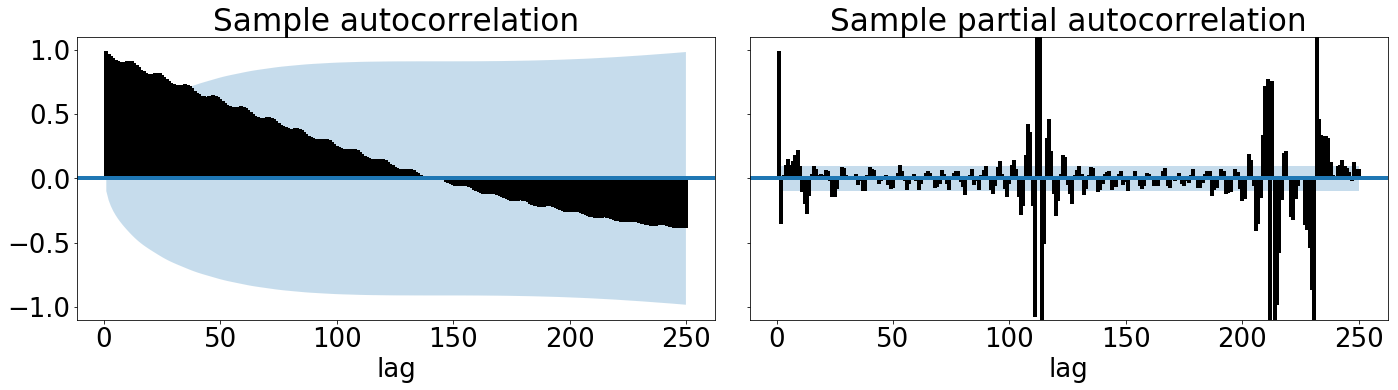

In [131]:
correlation_diagnostics(dataset[target_column], lags=250);

* On the **left plot** autocorrelation of small lags is near to $1.0$ and decreases pretty slowly
* On the **right plot** observations with lag $1$, $110$, $215$ has statistically non-null net effect

It is indication of very typical kind of non-stationarity: $y_t = y_{t-1} + \ldots$.

That means it is observed strong dependance of the past (the history of a process).

---

# Key steps of model construction for time series

* Stationarize a time series
* Estimate parameter of the model
* Visualize remains after stationarization
  * check if respect the model requirements
* Validation of the model